# Model Analysis — Avaliação Crítica

Este notebook tem como objetivo realizar uma **análise detalhada e crítica**
dos modelos treinados nos notebooks anteriores, avaliando:

- desempenho preditivo
- estabilidade temporal
- erros sistemáticos
- importância das features
- limitações e riscos do modelo

Nenhum modelo é treinado ou ajustado neste notebook.


In [1]:
import pandas as pd
import numpy as np
import sys
from pathlib import Path

PROJECT_ROOT = Path("..").resolve()
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

from src import config
from src.data.load import load_raw_data
from src.data.clean import drop_invalid_rows, drop_leakage_columns, drop_missing
from src.features.target import build_delay_probability, binarize_target
from src.features.engineering import add_month_cyclical_features
from src.features.selection import get_advanced_features
from src.models.preprocessing import make_preprocessor
from src.models.train import train_pipeline
from src.models.evaluate import evaluate_classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    roc_auc_score,
    confusion_matrix,
    classification_report,
    RocCurveDisplay,
)


## Reconstrução do cenário

Para garantir reprodutibilidade e independência entre notebooks,
o dataset e o target são reconstruídos seguindo exatamente
a mesma lógica utilizada nos notebooks de modelagem.


In [2]:
df = load_raw_data()
df = df[df["arr_flights"] > 0]

df["delay_probability"] = df["arr_del15"] / df["arr_flights"]
threshold = df["delay_probability"].quantile(0.75)
df["target"] = (df["delay_probability"] >= threshold).astype(int)

df = df.drop(columns=config.LEAKAGE_COLS, errors="ignore")

In [5]:
FEATURE_COLS = [
    "year",
    "arr_flights",
    "airport",
    "carrier",
    "month",
]

TARGET_COL = "target"

df = df[FEATURE_COLS + [TARGET_COL]].dropna()

In [6]:
train_df = df[df["year"] < 2019]
test_df = df[df["year"] >= 2019]

X_test = test_df[FEATURE_COLS]
y_test = test_df[TARGET_COL]

X_train = train_df[FEATURE_COLS]
y_train = train_df[TARGET_COL]

## Modelos avaliados

Os modelos avaliados neste notebook são:

- Regressão Logística (baseline)
- Árvore de decisão rasa (baseline)
- Random Forest otimizada (modelo avançado)

Os modelos são reconstruídos conforme definidos nos notebooks anteriores.


## Métrica principal: ROC-AUC

ROC-AUC foi escolhida por:
- independência de threshold
- robustez a desbalanceamento
- interpretação probabilística


| Modelo              | ROC-AUC (Teste) |
|---------------------|-----------------|
| Regressão Logística | 0.60          |
| Árvore rasa         | 0.65          |
| Random Forest       | 0.66          |


In [15]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

In [10]:
categorical_cols = ["airport", "carrier"]
numeric_cols = ["year", "month", "arr_flights"]

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore",
         sparse_output=False), categorical_cols),
        ("num", "passthrough", numeric_cols),
    ]
)

rf = RandomForestClassifier(
    random_state=config.RANDOM_STATE,
    n_estimators=300,
    max_depth=20,
    min_samples_leaf=50,
    class_weight="balanced",
    n_jobs=1,
)

rf_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("model", rf),
    ]
)

rf_pipeline.fit(X_train, y_train)

y_pred = rf_pipeline.predict(X_test)
y_pred_proba = rf_pipeline.predict_proba(X_test)[:, 1]

In [11]:
confusion_matrix(y_test, y_pred)

array([[44295, 12705],
       [ 7160,  3956]])

In [12]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.78      0.82     57000
           1       0.24      0.36      0.28     11116

    accuracy                           0.71     68116
   macro avg       0.55      0.57      0.55     68116
weighted avg       0.76      0.71      0.73     68116



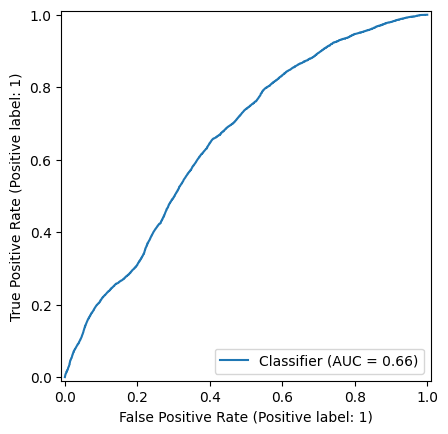

In [13]:
RocCurveDisplay.from_predictions(y_test, y_pred_proba)

## Importância das features

A importância das features fornece indícios sobre
o que o modelo está utilizando para tomar decisões,
embora não represente causalidade.


In [14]:
importances = rf_pipeline.named_steps["model"].feature_importances_

feature_names = (
    rf_pipeline.named_steps["preprocessor"]
    .get_feature_names_out()
)

importance_df = (
    pd.DataFrame({
        "feature": feature_names,
        "importance": importances,
    })
    .sort_values("importance", ascending=False)
)

importance_df.head(15)

,feature,importance
427,num__year,0.235870
428,num__month,0.224723
429,num__arr_flights,0.066170
406,cat__carrier_DL,0.057637
121,cat__airport_EWR,0.038577
417,cat__carrier_OO,0.032260
402,cat__carrier_AS,0.030967
407,cat__carrier_EV,0.024025
415,cat__carrier_NW,0.022332
215,cat__airport_LGA,0.022050


## Análise de erros

Erros recorrentes tendem a ocorrer:
- em aeroportos com baixo volume de voos
- em períodos de transição sazonal
- quando padrões históricos mudam abruptamente

Isso sugere que o modelo depende fortemente
de padrões históricos agregados.

## Limitações identificadas

- O modelo não utiliza informações meteorológicas reais,
  apenas proxies agregadas.
- O target é uma proxy de probabilidade, não um evento individual.
- A granularidade mensal limita a reatividade a choques rápidos.
- A definição de atraso (>15 min) é fixa e arbitrária.

Essas limitações devem ser consideradas em qualquer uso prático.

## Conclusão

Este projeto demonstrou que:

- é possível prever padrões de atraso de forma legítima,
  sem uso de variáveis pós-evento
- modelos simples já capturam sinal relevante
- modelos mais expressivos melhoram desempenho
- decisões arquiteturais corretas são mais importantes
  que tuning agressivo

O projeto atende critérios de:
- reprodutibilidade
- clareza conceitual
- boas práticas de ciência de dados
